<a href="https://colab.research.google.com/github/Gedeon-m-gedus/Image_Processing/blob/master/CV_02_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt
import time

In [0]:
# Convert vector to image
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

In [0]:
bs = 1000

transform = transforms.Compose([transforms.ToTensor()])

traindataset = FashionMNIST('./data', download=True, train=True, transform=transform)
testdataset = FashionMNIST('./data', download=True, train=False, transform=transform)

# Loaders
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=bs, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=bs, shuffle=False, num_workers=4)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [0]:
# Displaying routine
def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [0]:
####model class
import torch.nn as nn
import torch.nn.functional as F
z_size = 54
class Variation_AutoEncoder(nn.Module):
    def __init__(self):
        super(Variation_AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
        nn.Conv2d(1,16,3),
        nn.Conv2d(16, 4, 3)
        )
        self.linear_mu = nn.Linear(24*4*24 , 24*4*24 )#24*4*24 , z_size
        self.linear_var = nn.Linear(4*24*24, 24*4*24 )
        

        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(4, 16, 3),
        nn.ConvTranspose2d(16, 1, 3)
        )
        
    def forward(self, x):
        #print('input',x.shape)
        x = F.relu(self.encoder(x))
        #print('enc',x.shape)
        x = x.view(1000,-1)
        #print(x.shape)
        mu = self.linear_mu(x)
        #print('mu',mu.shape)
        log_var = self.linear_var(x)
        #print('var',log_var.shape)
        z = self.reparametrize(mu, log_var)
        #print('z',z.shape)
        z = z.view(1000,4,24,24)
        #print(z.shape)
        out = F.relu(self.decoder(z))      
        return out,mu,log_var

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.rand_like(std)
        return mu + std * eps

model = Variation_AutoEncoder()
print(model)  

Variation_AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1))
  )
  (linear_mu): Linear(in_features=2304, out_features=2304, bias=True)
  (linear_var): Linear(in_features=2304, out_features=2304, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)


In [0]:
# Configure the criterion
criterion = nn.MSELoss()
#criterion = nn.BCELoss()

In [0]:
def loss_function(recon_x, x, mu, logvar):
    
    #recon_x: generating images
    #x: origin images
    #mu: latent mean
    #logvar: latent log variance
   
    BCE = criterion(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD

epoch [1/10], loss:0.1032
epoch [2/10], loss:0.1003
epoch [3/10], loss:0.1010
epoch [4/10], loss:0.0989
epoch [5/10], loss:0.0976
epoch [6/10], loss:0.0975
epoch [7/10], loss:0.0982
epoch [8/10], loss:0.1004
epoch [9/10], loss:0.0964
epoch [10/10], loss:0.0987


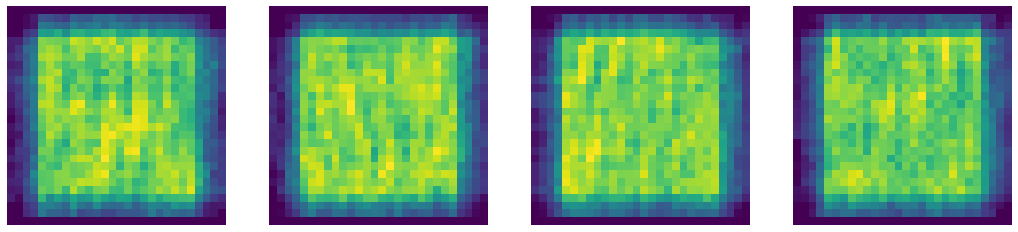

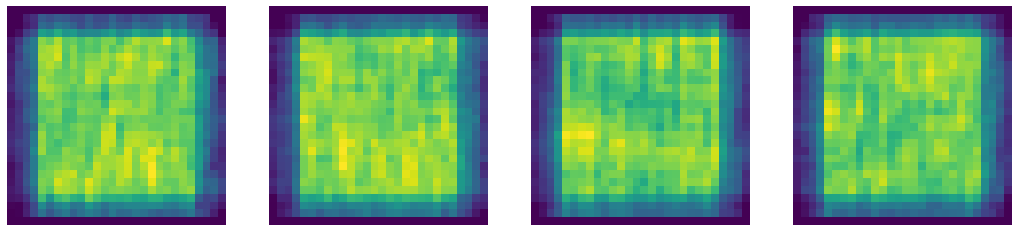

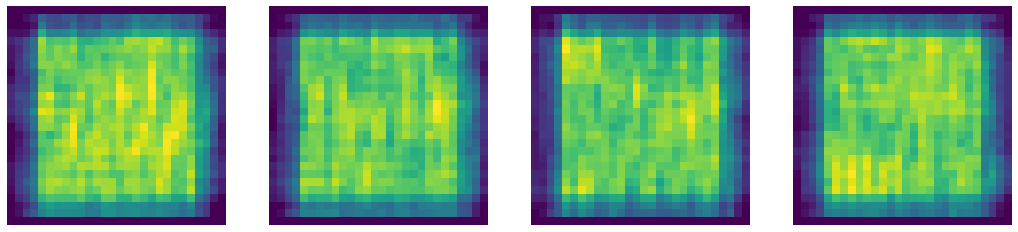

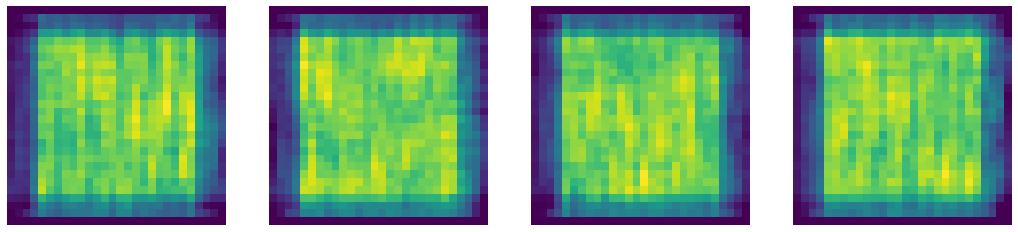

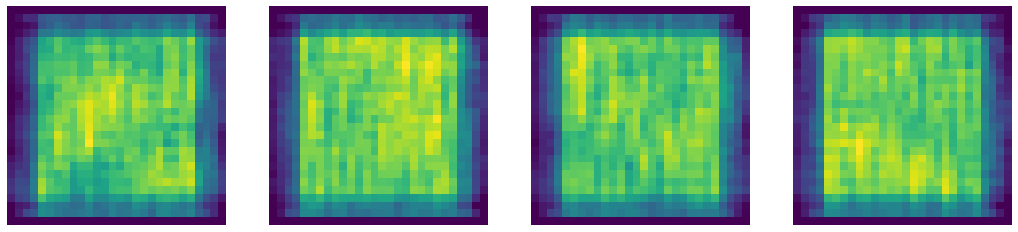

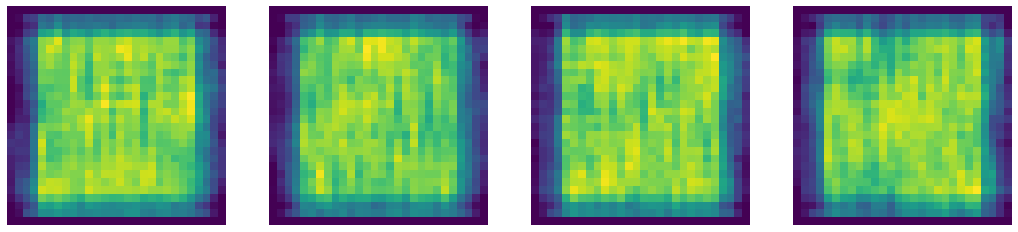

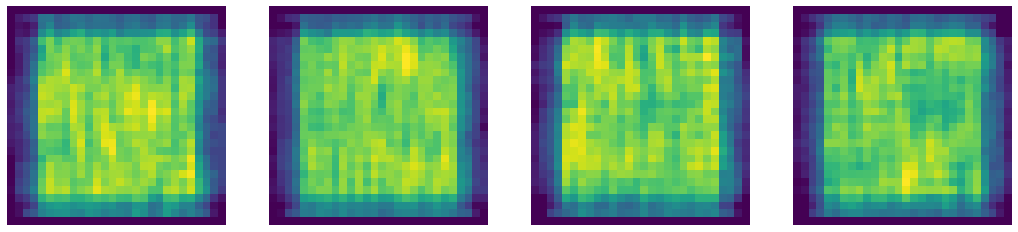

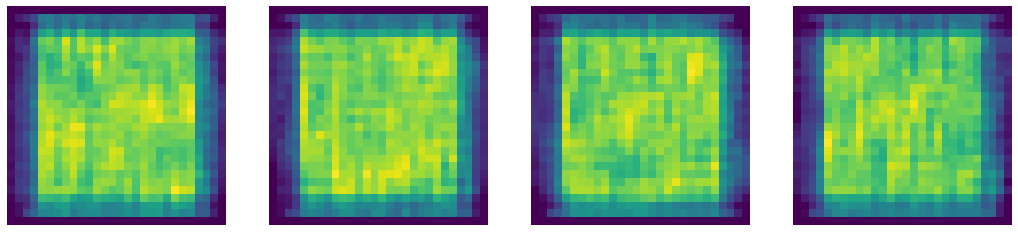

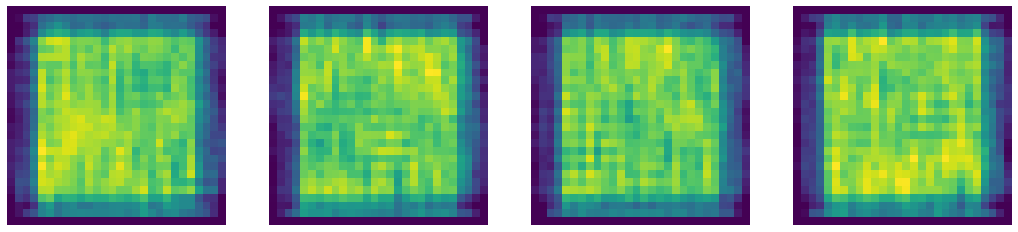

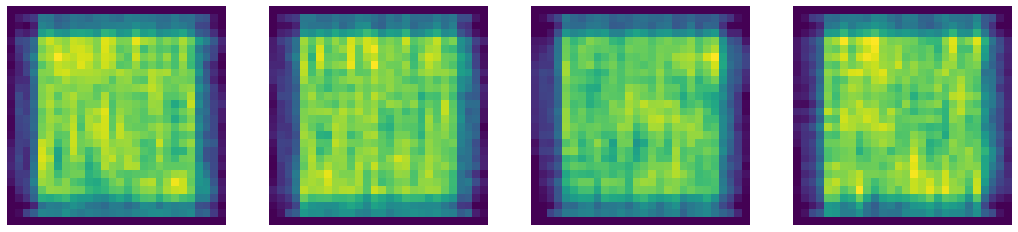

In [0]:
#configure optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10
f_loss = []
t1 = time.perf_counter()
for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        img.requires_grad_()
        #img = img.view(img.size(0), -1)
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)  
        #loss = criterion(output, img.data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        f_loss.append(loss.item())
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, recon_batch)
t2 = time.perf_counter()
t = t2 - t1

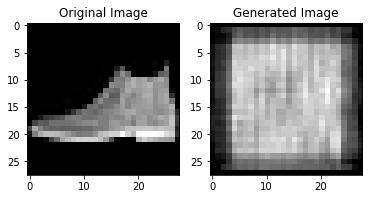

In [0]:
from torch.autograd import Variable
plt.style.use('default')
%matplotlib inline 
test_images, labels = next(iter(testloader))

#test_images = Variable(test_images.view(test_images.size()[0], -1))
test_output,k,kk = model(test_images)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

fig = plt.figure()
plot = fig.add_subplot(1, 2, 1)
plot.set_title('Original Image')
imgplot = plt.imshow(inp[0].cpu(), cmap='gray')

plot = fig.add_subplot(1, 2, 2)
plot.set_title('Generated Image')
imgplot = plt.imshow(out[0].cpu().detach(), cmap='gray')
plt.show()

Text(0, 0.5, 'Loss')

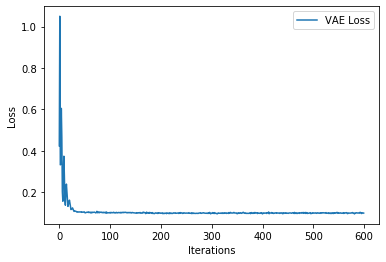

In [0]:
plt.plot([i for i in range(len(f_loss))], f_loss,label='VAE Loss')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")